In [1]:
#utils
import copy
import random

grid_small = \
        [
        [0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]

grid_random = [[ random.random()>0.9 for col in range(25)] for row in range(25)]
init = [0, 0]

cost = 1 # the cost associated with moving from a cell to an adjacent one
delta = [[-1, 0 ], # go up
         [ 0, -1], # go left
         [ 1, 0 ], # go down
         [ 0, 1 ]] # go right
delta_name = ['^', '<', 'v', '>']
def map_2_goals(grid, value_to_search = 0):
    '''Get list of all unopened nodes'''
    return [(ix,iy) for ix, row in enumerate(grid) for iy, i in enumerate(row) if i == value_to_search]

def compute_value(goals):
    '''Heurisitic for A*'''
    def fun(x, y):
        def dist(x_g, y_g):
            return (x_g-x)**2+(y_g-y)**2
        x_g, y_g = min(goals, key = lambda g: dist(g[0],g[1]))
        value = dist(x_g, y_g)
        return value
    return fun

class Node(object):
    '''Linked list for storing path and A*'''
    def __init__(self, he, cost, x, y):
        self.x = x
        self.y = y
        self.p = None
        self.cost = cost
        self.he = he
    def add(self, child):
        child.p = self
        child.cost = self.cost + child.cost
        child.he = child.cost + child.he
        

In [24]:
# Core of CPP
def a_star(grid,init,cost,goals, heuristic):
    '''Basic path planning eg A*'''
    closed = [[0 for col in range(len(grid[0]))] for row in range(len(grid))]
    closed[init.x][init.y] = 1

    open1 = [init]

    found = False  # flag that is set when search is complete
    resign = False # flag set if we can't find expand
    
    while not found and not resign:
        if len(open1) == 0:
            resign = True
            return resign, init
        else:
            open1.sort(key=lambda x: x.he, reverse=True)
            nn = open1.pop()
            if goals[nn.x][nn.y]==0:
                found = True
                return resign, nn
            else:
                prev = nn.p
                if prev is not None:
                    dx = nn.x - prev.x
                    dy = nn.y - prev.y
                    dx, dy = -dy, dx
                else:
                    dx = 0
                    dy = 1
                
                for i in range(4):
                    x2 = nn.x + dx
                    y2 = nn.y + dy
                    if x2 >= 0 and x2 < len(grid) and y2 >=0 and y2 < len(grid[0]):
                        if closed[x2][y2] == 0 and grid[x2][y2] == 0:
                            # heuristic  has to be designed to prefer a CCW turns
                            new_node = Node(heuristic(x2, y2)+i, cost, x2, y2)
                            nn.add(new_node)
                            open1.append(new_node)
                            closed[x2][y2] = 1
                    dx, dy = dy, -dx
                    

def spiral(grid, init, visited):
    '''Spiral filling of the open space'''
    end = init
    prev = init.p
    done = False
    while not done:
        #try turn ccw
        if prev is not None:
            dx = end.x - prev.x
            dy = end.y - prev.y
            dx, dy = -dy, dx
        else:
            dx = 0
            dy = 1
        done = True

        for i in range(4):
            x2 = end.x + dx
            y2 = end.y + dy
            if x2 >= 0 and x2 < len(grid) and y2 >=0 and y2 < len(grid[0]):
                if grid[x2][y2] == 0  and visited[x2][y2] == 0:
                    new_node = Node(0, 0, x2, y2)
                    end.add(new_node)
                    prev = end
                    end = new_node
                    visited[x2][y2] = 1
                    done = False
                    break
            #try next direciton cw
            dx, dy = dy, -dx
    return visited, end
                
def naive_cpp(grid, init):
    visited = copy.deepcopy(grid)
    
    x = init[0]
    y = init[1]
    end_node = Node(0, 0, x, y)
    visited[x][y] = 1
    
    visited, end_node = spiral(grid, end_node, visited)
    goals = map_2_goals(visited)
    it = 0
    #dump part of the trajectory for visualzation
    yield end_node
    end_node.p = None
    while len(goals) != 0:    
        def dist(x_g, y_g):
            return (x_g-end_node.x)**2+(y_g-end_node.y)**2
        goals.sort(key = lambda g: dist(g[0],g[1]))
        resign, end_node = a_star(grid, end_node, 1, visited, compute_value(goals[:min([50,len(goals)])]))
        if resign:
            break
        nn = end_node
        count = 0
        while nn is not None:
            visited[nn.x][nn.y] = 1           
            nn = nn.p
#         #dump part of the trajectory for visualzation    
#         yield end_node
#         end_node.p = None
        
        visited, end_node = spiral(grid, end_node, visited)
        goals = map_2_goals(visited)
        #dump part of the trajectory for visualzation
        yield end_node
        end_node.p = None
    #return end_node


In [25]:
# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import os
import matplotlib.image as mpimg
from skimage import img_as_ubyte
import cv2
import numpy as np
%matplotlib inline
from IPython import display
def plot_cpp_naive(grid, ax, with_boxes, axis_flip = -1):
    path_cpp_gen = naive_cpp(grid,init)

    for path_cpp in path_cpp_gen:
        nn = path_cpp
        path_x = [] 
        path_y = []
        while nn is not None:
            #print(nn.x,nn.y)
            path_x.append(axis_flip*nn.x)
            path_y.append(nn.y)
            nn = nn.p
        display.display(plt.gcf())
        #plt.cla()
        display.clear_output(wait=True)
        len(path_x)
        ax.plot(path_y,path_x, alpha=0.3, linewidth = 4.0)
        if with_boxes:
            for x, y  in zip(path_y,path_x):
                fancybox = mpatches.FancyBboxPatch(
                            [x-0.5, y-0.5], 1, 1,
                            boxstyle=mpatches.BoxStyle("Round", pad=0.02))
                fancybox.set_alpha(0.1)
                fancybox.set_color("green")
                ax.add_patch(fancybox)


# Visualization section

The 3 runs of CCP Sprial-STC is visualized below:

+ On predifinded small grid
+ On random medium size grid
+ On an big pixel image, where robot size is considered as 1 px

In each run an image is generated. On the image following legend is used:

+ red squares are obstables
+ green coverd area (darker green shows mulitiple passes)
+ colored lines are generated setpoins. Each color represent a set of points genereated in one iteration of the algorithm

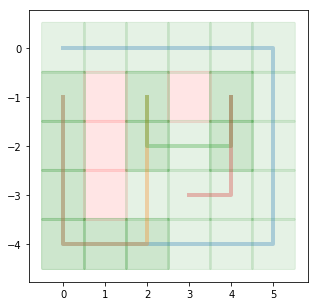

In [26]:

def scope():
    fig, ax = plt.subplots(figsize=(5,5))
    for y, x in map_2_goals(grid_small,1):
        fancybox = mpatches.FancyBboxPatch(
                        [x-0.5, -y-0.5], 1, 1,
                        boxstyle=mpatches.BoxStyle("Round", pad=0.02))
        fancybox.set_alpha(0.1)
        fancybox.set_color("red")
        ax.add_patch(fancybox)
    plot_cpp_naive(grid_small, ax, True)
scope()

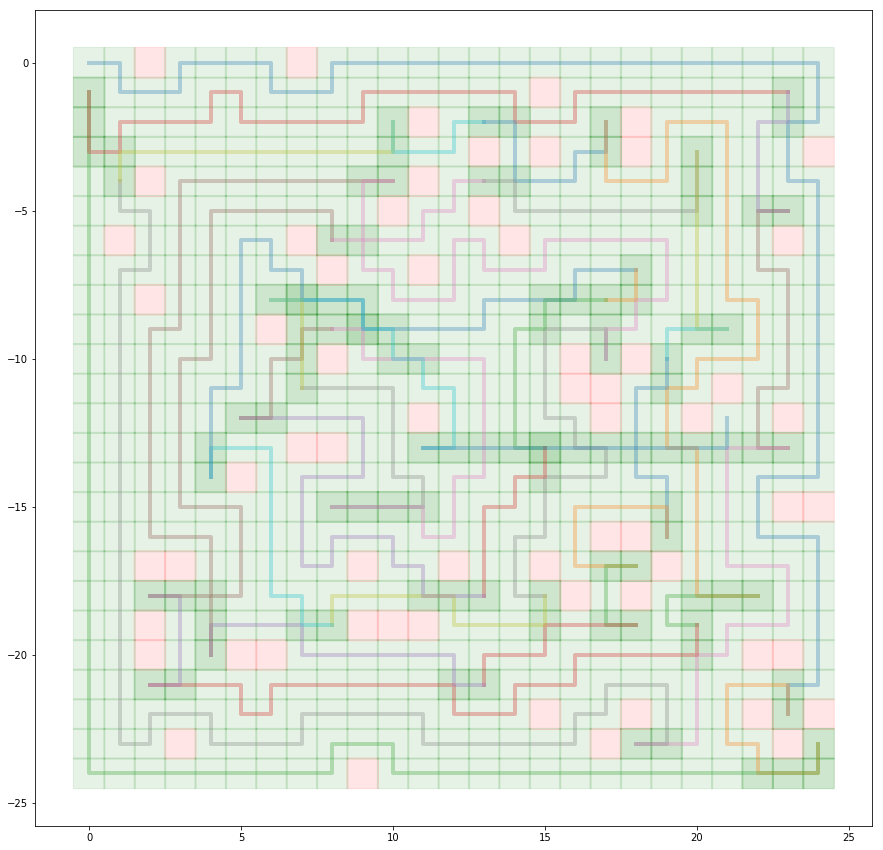

In [27]:
def scope():
    fig, ax = plt.subplots(figsize=(15,15))
    for y, x in map_2_goals(grid_random,1):
        fancybox = mpatches.FancyBboxPatch(
                        [x-0.5, -y-0.5], 1, 1,
                        boxstyle=mpatches.BoxStyle("Round", pad=0.02))
        fancybox.set_alpha(0.1)
        fancybox.set_color("red")
        ax.add_patch(fancybox)
    plot_cpp_naive(grid_random,ax,True)
scope()

(400, 640)


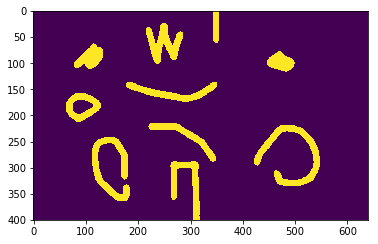

In [29]:

def getOccupancyGridImage(file_name):
    image = mpimg.imread(file_name)
    print(image.shape)
    return np.round(1-np.array(image)).astype(np.int)
plt.imshow(getOccupancyGridImage('./test_map.png'))

In this visualization obstacles are shown in black and green covarge squares are omitted as those would not be seen at this resolution.

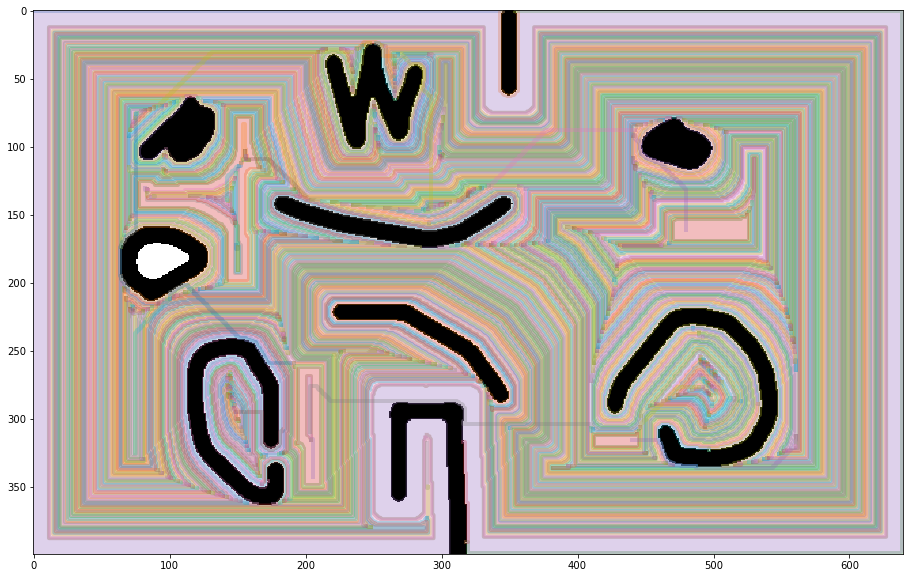

In [30]:
def scope():
    grid = getOccupancyGridImage('./test_map.png')
    fig, ax = plt.subplots(figsize=(16,10))
    ax.imshow(1-grid,interpolation='nearest', cmap='gray')
    plot_cpp_naive(grid,ax,False, 1)
scope()